In [38]:
import pandas as pd
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb 
import os
import sys
import numpy as np
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt

In [39]:
ot_odr_filename = os.path.join(".", "OT_ODR.csv.bz2")
ot_odr_df = pd.read_csv(ot_odr_filename,
                        compression="bz2",
                        sep=";")

equipements_filename = os.path.join(".", 'EQUIPEMENTS.csv')
equipements_df = pd.read_csv(equipements_filename,
                             sep=";")

ot_odr_df["SYSTEM_N2"].replace("-", "NONE", inplace=True)

var_sig = ["SIG_ORGANE", "SIG_CONTEXTE", "SIG_OBS"]
ot_odr_df[var_sig].describe()

var_sys = ["SYSTEM_N1", "SYSTEM_N2", "SYSTEM_N3"]
ot_odr_df[var_sys].describe()

var_odr = ["TYPE_TRAVAIL", "ODR_LIBELLE"]
ot_odr_df[var_odr].describe()

var_cat = ['ODR_LIBELLE', 'TYPE_TRAVAIL',
           'SYSTEM_N1', 'SYSTEM_N2', 'SYSTEM_N3', 
           'SIG_ORGANE', 'SIG_CONTEXTE', 'SIG_OBS', 'LIGNE']
for var in var_cat:
    ot_odr_df[var] = ot_odr_df[var].astype('category')

ot_odr_df.info()

var_to_model = ["SYSTEM_N2", "SIG_OBS", "SIG_ORGANE"]

var_bn = {}

for var in var_to_model:
    nb_values = len(ot_odr_df[var].cat.categories)
    var_bn[var] = gum.LabelizedVariable(var, var, nb_values)

for var in var_bn:
    for i, modalite in enumerate(ot_odr_df[var].cat.categories):
        var_bn[var].changeLabel(i, modalite)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506558 entries, 0 to 506557
Data columns (total 15 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   OT_ID          506558 non-null  object  
 1   ODR_ID         506558 non-null  object  
 2   ODR_LIBELLE    506558 non-null  category
 3   TYPE_TRAVAIL   506558 non-null  category
 4   DUREE_TRAVAIL  506558 non-null  float64 
 5   SYSTEM_N1      506558 non-null  category
 6   SYSTEM_N2      506558 non-null  category
 7   SYSTEM_N3      506558 non-null  category
 8   EQU_ID         506558 non-null  object  
 9   DATE_OT        506558 non-null  object  
 10  KILOMETRAGE    506557 non-null  float64 
 11  SIG_ORGANE     506558 non-null  category
 12  SIG_CONTEXTE   506558 non-null  category
 13  SIG_OBS        506558 non-null  category
 14  LIGNE          506558 non-null  category
dtypes: category(9), float64(2), object(4)
memory usage: 29.7+ MB


In [40]:
bn = gum.BayesNet("modèle simple")

for var in var_bn.values():
    bn.add(var)

bn.addArc("SYSTEM_N2", "SIG_OBS")
bn.addArc("SYSTEM_N2", "SIG_ORGANE")

ot_odr_train_df = ot_odr_df[var_to_model].iloc[:400000]

learner = gum.BNLearner(ot_odr_train_df[var_to_model])

learner.fitParameters(bn)

bn.cpt("SIG_OBS")
bn.cpt("SIG_ORGANE")
bn.cpt("SYSTEM_N2")

(pyAgrum.Potential<double>@00000253239D7520) 
  SYSTEM_N2                                                                                                                                                                                                                                                                                                                                                                                                                                                      |
ACCESSIBI|ACCESSOIR|AIDE A L'|AMENAGEME|ARTICULAT|BOITE DE |CHASSIS  |CHAUFFAGE|CIRCUIT D|CIRCUIT D|CIRCUIT D|CIRCUIT D|CIRCUIT D|CIRCUIT D|CIRCUIT D|CIRCUIT D|CIRCUIT D|CIRCUIT D|CIRCUIT D|CLIMATISA|DEPOLLUTI|ECLAIRAGE|ELEMENT C|ENERGIE T|EQUIPEMEN|FREIN D'E|FREIN DE |FREIN PRI|FREIN SEC|INDICATEU|INFORMATI|LIAISON A|MAINTENAN|MOTEUR EL|MOTEUR TH|NONE     |PORTE    |POSTE DE |REFROIDIS|SECURITE |STOCKAGE |TELEBILLE|TRANSMISS|VENTILATI|VITRAGE  |
---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|
 0.0030  | 0.0694  | 0.0075  | 0.0136  | 0.0003  | 0.0022  | 0.0014  | 0.0238  | 0.0035  | 0.0001  | 0.0025  | 0.0034  | 0.0032  | 0.0033  | 0.0091  | 0.0030  | 0.0017  | 0.0184  | 0.0001  | 0.0002  | 0.0082  | 0.5226  | 0.0941  | 0.0000  | 0.0029  | 0.0027  | 0.0017  | 0.0178  | 0.0000  | 0.0324  | 0.0069  | 0.0223  | 0.0001  | 0.0000  | 0.0034  | 0.0004  | 0.0572  | 0.0119  | 0.0154  | 0.0040  | 0.0005  | 0.0185  | 0.0003  | 0.0021  | 0.0049  |

In [41]:
def predict(bn, data, var_target, show_progress=False):
    """
    This function is used to predict the posterior probability of a target variable from observations  
    using a bayesian network model. 

    Inputs:
    - =bn=: the predictive model given as a =pyAgrum.BayesNet= object
    - =data=: the data containing the observations used to predict the target variable 
    as a =pandas.DataFrame= object
    - =var_target=: the name of the target variable as a =str= object

    Returns:
    - a =DataFrame= containing the posterior probability distribution of the target 
    variable given each observation in =data=.
    """
    # Initialize the inference engine
    inf_bn = gum.LazyPropagation(bn)
    inf_bn.setTargets({var_target})
    nb_data = len(data)
    target_size = bn.variable(var_target).domainSize()
    target_dom = np.array([bn.variable(var_target).label(i)
                           for i in range(target_size)])
    data_records = data.to_dict("records")
    post_prob = np.zeros((nb_data, target_size))
    for i in range(nb_data):
        # Set the evidence
        inf_bn.setEvidence(data_records[i])
        # Run inference
        inf_bn.makeInference()
        # Compute posterior probability of target variable
        post_prob[i, :] = inf_bn.posterior(var_target).toarray()
        # Erase evidence
        inf_bn.eraseAllEvidence()
        if show_progress:
            sys.stdout.write("predict progress: {0:3.0%}\r".format(i/nb_data))

    post_prob_df = pd.DataFrame(post_prob,
                                index=data.index,
                                columns=bn.variable(var_target).labels())
    post_prob_df.columns.name = var_target
    return post_prob_df

0.8024550010323016100%


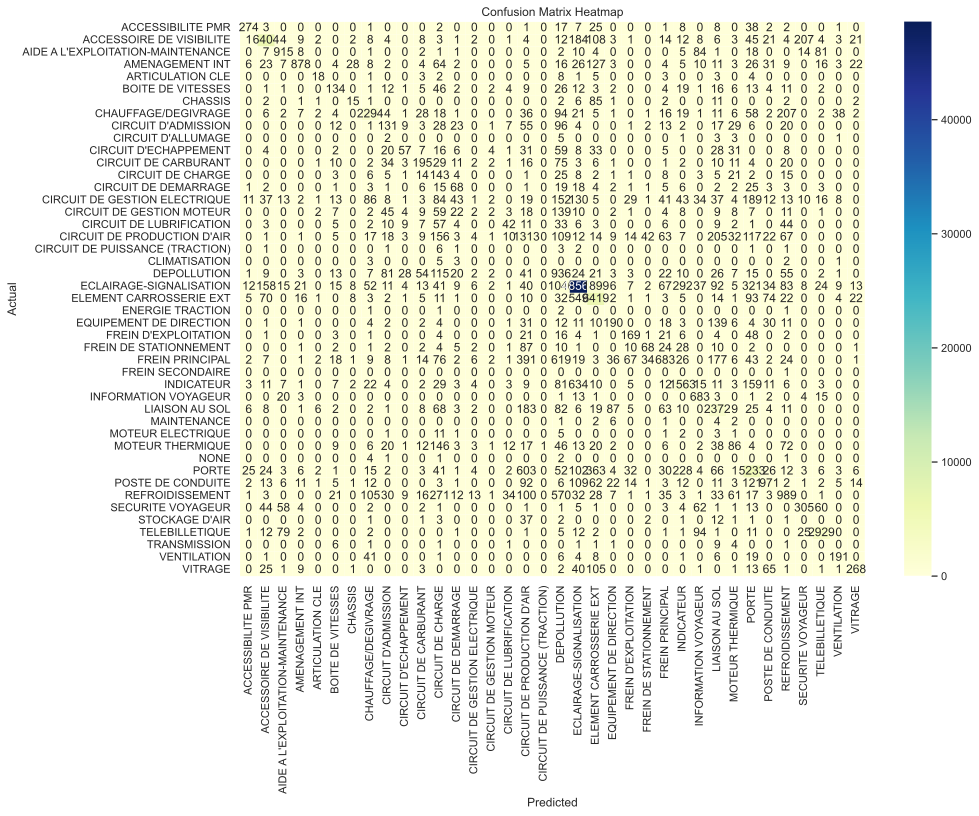

In [42]:
pred_prob = predict(bn,
                    data=ot_odr_df[["SIG_OBS","SIG_ORGANE"]].iloc[400000:], 
                    var_target="SYSTEM_N2",
                    show_progress=True)

pred_var = pred_prob.idxmax(axis=1).rename("pred")

print((ot_odr_df["SYSTEM_N2"].iloc[400000:] == pred_var).mean())

conf_mat = pd.crosstab(ot_odr_df["SYSTEM_N2"].iloc[400000:], pred_var)

plt.figure(figsize=(14, 10))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="YlGnBu", cbar=True)
plt.title("Confusion Matrix Heatmap")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()